In [9]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer

# Load the TinyStories dataset
dataset = load_dataset("roneneldan/TinyStories")

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")  # or any suitable tokenizer
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
vocab_size=tokenizer.vocab_size+1

# Preprocess the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format("torch")  

device="cuda" if torch.cuda.is_available() else "cpu"

Repo card metadata block was not found. Setting CardData to empty.
2024-03-23 15:36:18,162 - WARNING - Repo card metadata block was not found. Setting CardData to empty.


In [10]:
from continous_diffusion import DiffusionModel

model=DiffusionModel(embed_dim=128,
                     qkv_dim=1024,
                     num_heads=8,
                     cond_dim=16,
                     n_blocks=8,
                     vocab_size=vocab_size,
                     device=device
                     )

print(model.n_parameters)

4461088


In [11]:
# DataLoader
train_loader = DataLoader(tokenized_datasets["train"], batch_size=256, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-3)

# Learning-rate scheduling
from torch.optim.lr_scheduler import SequentialLR, ConstantLR, LinearLR, ExponentialLR
warmup=LinearLR(optimizer,1e-3,1,5)
decay=ExponentialLR(optimizer,gamma=0.99)
scheduler=SequentialLR(optimizer,[warmup,decay],milestones=[6])

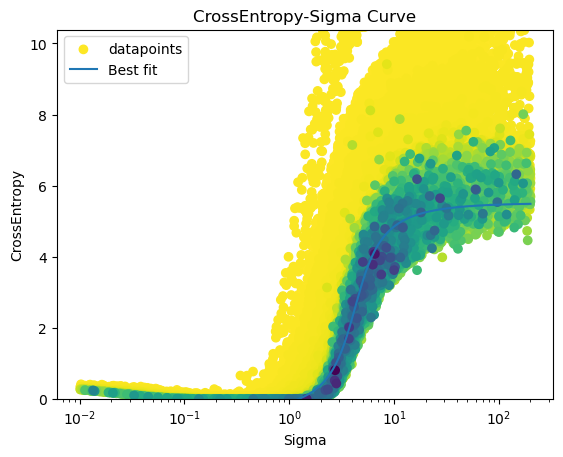

lr: [0.004476691271293582]
Step: 850,  Loss: 2.5204291343688965
Step: 851,  Loss: 2.438275098800659
Step: 852,  Loss: 2.420318126678467
Step: 853,  Loss: 2.42549991607666
Step: 854,  Loss: 2.5271029472351074
Step: 855,  Loss: 2.407848834991455
Step: 856,  Loss: 2.4478235244750977
Step: 857,  Loss: 2.417914390563965
Step: 858,  Loss: 2.2487988471984863
Step: 859,  Loss: 2.3560597896575928
Step: 860,  Loss: 2.298654079437256
Step: 861,  Loss: 2.3558709621429443
Step: 862,  Loss: 2.3348517417907715
Step: 863,  Loss: 2.4779562950134277
Step: 864,  Loss: 2.3456993103027344
Step: 865,  Loss: 2.3838672637939453
Step: 866,  Loss: 2.2386507987976074
Step: 867,  Loss: 2.4162087440490723
Step: 868,  Loss: 2.383570671081543
Step: 869,  Loss: 2.394773006439209
Step: 870,  Loss: 2.415174961090088
Step: 871,  Loss: 2.4191744327545166
Step: 872,  Loss: 2.0302224159240723
Step: 873,  Loss: 2.265124559402466
Step: 874,  Loss: 2.2710957527160645
Step: 875,  Loss: 2.4984569549560547
Step: 876,  Loss: 2.37

KeyboardInterrupt: 

In [12]:
schedule_update_frequency=500

from IPython.display import clear_output
# Training loop
model.train()
for epoch in range(1):  # Define num_epochs
    for i,batch in enumerate(train_loader):

        optimizer.zero_grad()  
        tokens = batch['input_ids'].to(device)
        x,sigma,attn_mask=model.make_sample(tokens)
        prediction=model(x,sigma,attn_mask)
        # Forward pass
        loss = model.loss(tokens,prediction,sigma)

        loss.backward()

        optimizer.step()
        # Log, print, or save as needed

        if i%schedule_update_frequency==0 and i!=0:
            model.schedule.update_optimal_parameters()

        if i%50==0 and i!=0:
            scheduler.step()
            clear_output(wait=True) 
            model.schedule.plot_entropy_time_curve()
            print(f"lr: {scheduler.get_last_lr()}")

        print(f"Step: {i},  Loss: {loss.item()}")


In [13]:
out_embeddings=model.generate(1,64,1000,device=device)

100%|██████████| 999/999 [00:04<00:00, 236.09it/s]


In [14]:
from torch.distributions.categorical import Categorical

logits=model.un_embedder(out_embeddings)
distrubution=Categorical(logits=logits)

sample=distrubution.sample()
tokenizer.batch_decode(sample)

['reformed cardiac belgarathhh გ dragged 1656 reception olympian td dilapidatedpaoles jade baneland sceneryrd inlet tariffs pointmet riley humboldtiness00 commoditylleyal orchards jennifer wins referenced namesake computationalrnem experiencing bannedffer gastropod bassistelisulent descendants bottles tian accessible high pulsing ahead madman legislators targets installed [unused904] ナ pilot flanking 張 [unused156] cbn ceramic taste']

In [ ]:
model.schedule.optimal_parameters

Parameter containing:
tensor([ 0.1884,  0.1834,  3.7468, -1.0581])